# Stage 3: Regulatory inference

In this tutorial, we will show how to conduct regulatory inference using GLUE feature embeddings. We continue with the previous example of scRNA-seq and scATAC-seq data integration.

In this example, the GLUE-based regulatory inference is used to identify significant cis-regulatory regions (ATAC peaks) for each gene. We will also demonstrate how to build TF-target gene regulatory graph based on the GLUE-inferred cis-regulatory regions, using additional information about TF binding sites.

In [1]:
import anndata as ad
import networkx as nx
import numpy as np
import pandas as pd
import scglue
import seaborn as sns
from IPython import display
from matplotlib import rcParams
from networkx.algorithms.bipartite import biadjacency_matrix
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
scglue.plot.set_publication_params()
rcParams['figure.figsize'] = (4, 4)

## Read intermediate results

First, read the intermediate results containing cell and feature embeddings from [stage 2](training.ipynb).

In [3]:
rna = ad.read_h5ad("rna-emb.h5ad")
atac = ad.read_h5ad("atac-emb.h5ad")
guidance_hvf = nx.read_graphml("guidance-hvf.graphml.gz")

We will be using genomic coordinates a lot in `BED` format. It is convenient to store the variable names as a "name" column.

In [4]:
rna.var["name"] = rna.var_names
atac.var["name"] = atac.var_names

Given that the GLUE model was trained on highly-variable features, regulatory inference will also be limited to these features. So, we extract the list of highly-variable features for future convenience.

In [5]:
genes = rna.var.query("highly_variable").index
peaks = atac.var.query("highly_variable").index

## Cis-regulatory inference with GLUE feature embeddings

> (Estimated time: negligible)

We first concatenate the feature indices and embeddings of the two modalities.

In [6]:
features = pd.Index(np.concatenate([rna.var_names, atac.var_names]))
feature_embeddings = np.concatenate([rna.varm["X_glue"], atac.varm["X_glue"]])

We would also need to extract a "skeleton" graph on which to conduct regulatory inference. The "skeleton" serves to limit the search space of potential regulatory pairs, which helps reduce false positives caused by spurious correlations.

* The regulatory scores are defined as the cosine similarity between feature embeddings. As cosine similarities are symmetric, we only choose one direction between RNA genes and ATAC peaks to avoid repeated computation.
* Self-loops are also ignored as self-regulation is not meaningfully modeled with the current model.

In [7]:
skeleton = guidance_hvf.edge_subgraph(
    e for e, attr in dict(guidance_hvf.edges).items()
    if attr["type"] == "fwd"
).copy()

Regulatory inference can be conducted by using the [scglue.genomics.regulatory_inference](api/scglue.genomics.regulatory_inference.rst) function. The function takes feature indices and embeddings as input, together with the skeleton graph generated above.

The resulting object is also a graph, with additional edge attributes:

* `"score"`: Regulatory score between genomic features, defined as cosine similair between feature embeddings;
* `"pval"`: *P*-value of the regulatory scores, obtained by comparing with a NULL distribution from shuffled feature embeddings;
* `"qval"`: *Q*-value of the regulatory scores, obtained by FDR correction of the *P*-values.

In [8]:
reginf = scglue.genomics.regulatory_inference(
    features, feature_embeddings,
    skeleton=skeleton, random_state=0
)

regulatory_inference:   0%|          | 0/25565 [00:00<?, ?it/s]

Significant regulatory connections can be extracted based on edge attribute (Q-value < 0.05).

In [9]:
gene2peak = reginf.edge_subgraph(
    e for e, attr in dict(reginf.edges).items()
    if attr["qval"] < 0.05
)

## Visualize the inferred cis-regulatory regions

> (Estimated time: negligible)

The inferred cis-regulatory connections can be visualized using [pyGenomeTracks](https://pygenometracks.readthedocs.io/en/latest/). You can install it via:

```sh
conda install -c bioconda pygenometracks
```

Before making the plot, we need to prepare input files for the `pygenometracks` CLI.

Specifically, we save the ATAC peaks in BED format, and the inferred gene-peak connections in "links" format:

In [10]:
scglue.genomics.Bed(atac.var).write_bed("peaks.bed", ncols=3)
scglue.genomics.write_links(
    gene2peak,
    scglue.genomics.Bed(rna.var).strand_specific_start_site(),
    scglue.genomics.Bed(atac.var),
    "gene2peak.links", keep_attrs=["score"]
)

Then prepare a track configuration file like below (see their [documentation](https://pygenometracks.readthedocs.io/en/latest/content/all_tracks.html) for more details):

In [11]:
%%writefile tracks.ini

[Score]
file = gene2peak.links
title = Score
height = 2
color = YlGnBu
compact_arcs_level = 2
use_middle = True
file_type = links

[ATAC]
file = peaks.bed
title = ATAC
display = collapsed
border_color = none
labels = False
file_type = bed

[Genes]
file = gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz
title = Genes
prefered_name = gene_name
height = 4
merge_transcripts = True
labels = True
max_labels = 100
all_labels_inside = True
style = UCSC
file_type = gtf

[x-axis]
fontsize = 12

Writing tracks.ini


Finally, we can call `pygenometracks` CLI to visualizing the inferred cis-regulatory connections within a proper genomic range (e.g., an area surrounding the *Gad2* gene):

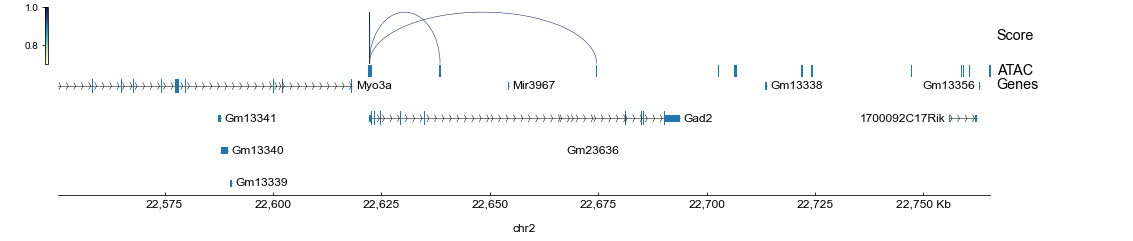

In [12]:
loc = rna.var.loc["Gad2"]
chrom = loc["chrom"]
chromLen = loc["chromEnd"] - loc["chromStart"]
chromStart = loc["chromStart"] - chromLen
chromEnd = loc["chromEnd"] + chromLen
!pyGenomeTracks --tracks tracks.ini \
    --region {chrom}:{chromStart}-{chromEnd} \
    --outFileName tracks.png 2> /dev/null
display.Image("tracks.png")

Note that in the tutorials, the guidance graph was constructed using only genomic overlap (see [Stage 1](preprocessing.ipynb#Graph-construction)), so the inferred regulatory connections are limited to the proximal promoter and gene body regions.

In real-world analyses, it would be beneficial to extend the genomic range (e.g., 150kb around TSS with distance-decaying weight) or incorporate additional information like Hi-C and eQTL (see our [case study](https://github.com/gao-lab/GLUE/tree/master/experiments/RegInf/s01_preprocessing.py) for an example).

## Construct TF-gene regulatory network from inferred cis-regulatory regions

Next, we demonstrate how to further construct TF-gene regulatory graph by combining the GLUE-inferred regulatory regions and TF motif/ChIP-seq information. Specifically, the [SCENIC pipeline](https://doi.org/10.1038/nmeth.4463) pipeline is adopted with the following 3 steps:

1. Generate a coexpression-based draft network using `GRNBoost2`;
2. Generate gene-wise TF cis-regulatory ranking by combining cis-regulatory regions and TF motif/ChIP-seq data;
3. Prune the coexpression-based draft network using the above cis-regulatory ranking with `cisTarget`.

To install pyscenic, use the following commands:

```sh
conda install -c conda-forge pyarrow cytoolz
pip install pyscenic
```

For human and mouse, the TF motif/ChIP-seq data used in the second step can be downloaded from here:

JASPAR motif hits:

* [http://download.gao-lab.org/GLUE/cisreg/JASPAR2022-hg19.bed.gz](http://download.gao-lab.org/GLUE/cisreg/JASPAR2022-hg19.bed.gz)
* [http://download.gao-lab.org/GLUE/cisreg/JASPAR2022-hg38.bed.gz](http://download.gao-lab.org/GLUE/cisreg/JASPAR2022-hg38.bed.gz)
* [http://download.gao-lab.org/GLUE/cisreg/JASPAR2022-mm9.bed.gz](http://download.gao-lab.org/GLUE/cisreg/JASPAR2022-mm9.bed.gz)
* [http://download.gao-lab.org/GLUE/cisreg/JASPAR2022-mm10.bed.gz](http://download.gao-lab.org/GLUE/cisreg/JASPAR2022-mm10.bed.gz)

ENCODE TF ChIP-seq:

* [http://download.gao-lab.org/GLUE/cisreg/ENCODE-TF-ChIP-hg38.bed.gz](http://download.gao-lab.org/GLUE/cisreg/ENCODE-TF-ChIP-hg38.bed.gz)
* [http://download.gao-lab.org/GLUE/cisreg/ENCODE-TF-ChIP-hg19.bed.gz](http://download.gao-lab.org/GLUE/cisreg/ENCODE-TF-ChIP-hg19.bed.gz)
* [http://download.gao-lab.org/GLUE/cisreg/ENCODE-TF-ChIP-mm10.bed.gz](http://download.gao-lab.org/GLUE/cisreg/ENCODE-TF-ChIP-mm10.bed.gz)
* [http://download.gao-lab.org/GLUE/cisreg/ENCODE-TF-ChIP-mm9.bed.gz](http://download.gao-lab.org/GLUE/cisreg/ENCODE-TF-ChIP-mm9.bed.gz)


Also see [pySCENIC](https://pyscenic.readthedocs.io/en/latest/index.html) for the original pipeline.

### Draft a coexpression-based network

> (Estimated time: ~5 min)

First, generate a list of eligible TFs. We use TFs covered in both the scRNA-seq dataset and TF motif/ChIP-seq data.

As ENCODE ChIP-seq covers a very limited number of mouse TFs, we will be using JASPAR motif hits in this tutorial:

In [13]:
motif_bed = scglue.genomics.read_bed("JASPAR2022-mm10.bed.gz")
motif_bed.head()

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,GL456210.1,159,171,Zbtb6,.,.,.,.,.,.,.,.
1,GL456210.1,242,253,Osr2,.,.,.,.,.,.,.,.
2,GL456210.1,266,278,Pou2f3,.,.,.,.,.,.,.,.
3,GL456210.1,505,517,Eomes,.,.,.,.,.,.,.,.
4,GL456210.1,507,516,Tbr1,.,.,.,.,.,.,.,.


In [14]:
tfs = pd.Index(motif_bed["name"]).intersection(rna.var_names)
tfs.size

532

Since pySCENIC CLI uses `loom` files as input, we need to save the scRNA-seq data as a `loom` file (with only highly-variable genes and TFs). We also need to save the list of TFs as a separate `txt` file.

In [15]:
rna[:, np.union1d(genes, tfs)].write_loom("rna.loom")
np.savetxt("tfs.txt", tfs, fmt="%s")

The loom file will lack these fields:
{'X_umap', 'X_pca', 'X_glue', 'PCs'}
Use write_obsm_varm=True to export multi-dimensional annotations


Now use the command `pyscenic grn` to build a coexpression-based draft network.

In [16]:
!pyscenic grn rna.loom tfs.txt \
    -o draft_grn.csv --seed 0 --num_workers 20 \
    --cell_id_attribute cells --gene_attribute genes


2022-08-12 12:30:12,903 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-08-12 12:30:13,236 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork fro

### Generate TF cis-regulatory ranking bridged by ATAC peaks

> (Estimated time: ~1 h)

We scan the genome with the [scglue.genomics.window_graph](api/scglue.genomics.window_graph.rst) function to connect ATAC peaks with TF motif hits based on genomic overlap. This will take some time (~1 hour).

In [17]:
peak_bed = scglue.genomics.Bed(atac.var.loc[peaks])
peak2tf = scglue.genomics.window_graph(peak_bed, motif_bed, 0, right_sorted=True)
peak2tf = peak2tf.edge_subgraph(e for e in peak2tf.edges if e[1] in tfs)

window_graph:   0%|          | 0/25488 [00:00<?, ?it/s]

Given the GLUE-inferred gene-peak connections and motif-supported peak-TF connections, the ATAC peaks can serve as a bridge to help deduce gene-TF connections.

Specifically, we can use the function [scglue.genomics.cis_regulatory_ranking](api/scglue.genomics.cis_regulatory_ranking.rst) to combine gene-peak and peak-TF connections into a gene-TF cis-regulatory ranking. Given that each gene can connect to a varying number of ATAC peaks with different lengths, the combined gene-TF connections are not directly comparable. As such, the function compares the observed connections with randomly sampled ones (stratified by peak length) to evaluate their levels of enrichment, which are then used to rank genes for each TF.

In [18]:
gene2tf_rank_glue = scglue.genomics.cis_regulatory_ranking(
    gene2peak, peak2tf, genes, peaks, tfs,
    region_lens=atac.var.loc[peaks, "chromEnd"] - atac.var.loc[peaks, "chromStart"],
    random_state=0
)
gene2tf_rank_glue.iloc[:5, :5]

/rd2/user/caozj/GLUE/conda/lib/python3.8/site-packages/scglue/genomics.py:724: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  gene2region = biadjacency_matrix(gene2region, genes, regions, dtype=np.int16, weight=None)
/rd2/user/caozj/GLUE/conda/lib/python3.8/site-packages/scglue/genomics.py:725: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  region2tf = biadjacency_matrix(region2tf, regions, tfs, dtype=np.int16, weight=None)


cis_reg_ranking.sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

cis_reg_ranking.mapping:   0%|          | 0/1000 [00:00<?, ?it/s]

,Zbtb6,Osr2,Pou2f3,Eomes,Tbr1
genes,,,,,
0610009B22Rik,1193.5,1211.0,1155.5,1115.5,1098.5
1110002J07Rik,1193.5,1211.0,1155.5,1115.5,1098.5
1110006O24Rik,1193.5,1211.0,1155.5,1115.5,1098.5
1110020A21Rik,1193.5,1211.0,1155.5,1115.5,1098.5
1110060G06Rik,1193.5,1211.0,1155.5,1115.5,1098.5


### Generate TF cis-regulatory ranking with proximal promoters (optional)

> (Estimated time: ~1 h)

One potential limitation of the above approach is that genes with no regulatory ATAC peaks identified would be left out. As a supplement, we can also use proximal promoter regions flanking the TSS to generate cis-regulatory ranking, as in the original pySCENIC pipeline.

To do that we scan the genome again with the [scglue.genomics.window_graph](api/scglue.genomics.window_graph.rst) function to connect TSS flanking regions (-500 to +500bp) with TF motif hits based on genomic overlap. Here the flanking regions will be named after the corresponding genes in the resulting graph.

In [19]:
flank_bed = scglue.genomics.Bed(rna.var.loc[genes]).strand_specific_start_site().expand(500, 500)
flank2tf = scglue.genomics.window_graph(flank_bed, motif_bed, 0, right_sorted=True)

window_graph:   0%|          | 0/2000 [00:00<?, ?it/s]

Similar to the previous section, we use the [scglue.genomics.cis_regulatory_ranking](api/scglue.genomics.cis_regulatory_ranking.rst) function to generate a supplementary cis-regulatory ranking, with the following differences:

* The gene-peak connection is replaced with a gene-flank connection, which is just a self-loop graph since each TSS flanking region have the same name as its corresponding gene;
* Since each gene has exactly one flanking region with the same length, it is unnecessary to evaluate TF enrichment with stratified random sampling, so we set `n_samples=0` to disable the sampling process.

In [20]:
gene2flank = nx.Graph([(g, g) for g in genes])
gene2tf_rank_supp = scglue.genomics.cis_regulatory_ranking(
    gene2flank, flank2tf, genes, genes, tfs,
    n_samples=0
)
gene2tf_rank_supp.iloc[:5, :5]

/rd2/user/caozj/GLUE/conda/lib/python3.8/site-packages/scglue/genomics.py:724: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  gene2region = biadjacency_matrix(gene2region, genes, regions, dtype=np.int16, weight=None)
/rd2/user/caozj/GLUE/conda/lib/python3.8/site-packages/scglue/genomics.py:725: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  region2tf = biadjacency_matrix(region2tf, regions, tfs, dtype=np.int16, weight=None)


,Zbtb6,Osr2,Pou2f3,Eomes,Tbr1
genes,,,,,
0610009B22Rik,1087.5,1053.5,1026.0,1016.5,1018.5
1110002J07Rik,1087.5,1053.5,1026.0,1016.5,1018.5
1110006O24Rik,1087.5,1053.5,1026.0,1016.5,1018.5
1110020A21Rik,1087.5,1053.5,1026.0,1016.5,1018.5
1110060G06Rik,1087.5,1053.5,1026.0,1016.5,1018.5


### Prune coexpression network using cis-regulatory ranking

> (Estimated time: ~5 min)

For the final step, we will prune the coexpression-based draft network with these cis-regulatory rankings to preserve TF-gene connections with cis-regulatory evidence. To do that, we need to prepare the following files:

* One or more `feather` files containing the cis-regulatory ranking;
* A `tsv` annotation file mapping column names in the ranking files to TF names.

Here we have two separate rankings (ATAC-based and promoter-based) with identical column names. We need to differentiate them by appending their information source.

In [21]:
gene2tf_rank_glue.columns = gene2tf_rank_glue.columns + "_glue"
gene2tf_rank_supp.columns = gene2tf_rank_supp.columns + "_supp"

We can use the [scglue.genomics.write_scenic_feather](api/scglue.genomics.write_scenic_feather.rst) function to save the cis-regulatory rankings as `feather` files compatible with `pySCENIC`.

In [22]:
scglue.genomics.write_scenic_feather(gene2tf_rank_glue, "glue.genes_vs_tracks.rankings.feather")
scglue.genomics.write_scenic_feather(gene2tf_rank_supp, "supp.genes_vs_tracks.rankings.feather")

Then use the following format for the annotation file:

In [23]:
pd.concat([
    pd.DataFrame({
        "#motif_id": tfs + "_glue",
        "gene_name": tfs
    }),
    pd.DataFrame({
        "#motif_id": tfs + "_supp",
        "gene_name": tfs
    })
]).assign(
    motif_similarity_qvalue=0.0,
    orthologous_identity=1.0,
    description="placeholder"
).to_csv("ctx_annotation.tsv", sep="\t", index=False)

We are now ready to prune the coexpression network. This can be achieved using the pySCENIC command `pyscenic ctx` (here `rank_threshold` was scaled down according to the number of highly-variable genes):

In [24]:
!pyscenic ctx draft_grn.csv \
    glue.genes_vs_tracks.rankings.feather \
    supp.genes_vs_tracks.rankings.feather \
    --annotations_fname ctx_annotation.tsv \
    --expression_mtx_fname rna.loom \
    --output pruned_grn.csv \
    --rank_threshold 500 --min_genes 1 \
    --num_workers 20 \
    --cell_id_attribute cells --gene_attribute genes 2> /dev/null

[########################################] | 100% Completed | 35.40 s


The resulting network can be read as a networkx graph using the [scglue.genomics.read_ctx_grn](api/scglue.genomics.read_ctx_grn.rst) function:

In [25]:
grn = scglue.genomics.read_ctx_grn("pruned_grn.csv")

## Visualize the inferred TF-target gene network

> (Estimated time: negligible)

The TF-target gene network can be visualized directly in networkx:

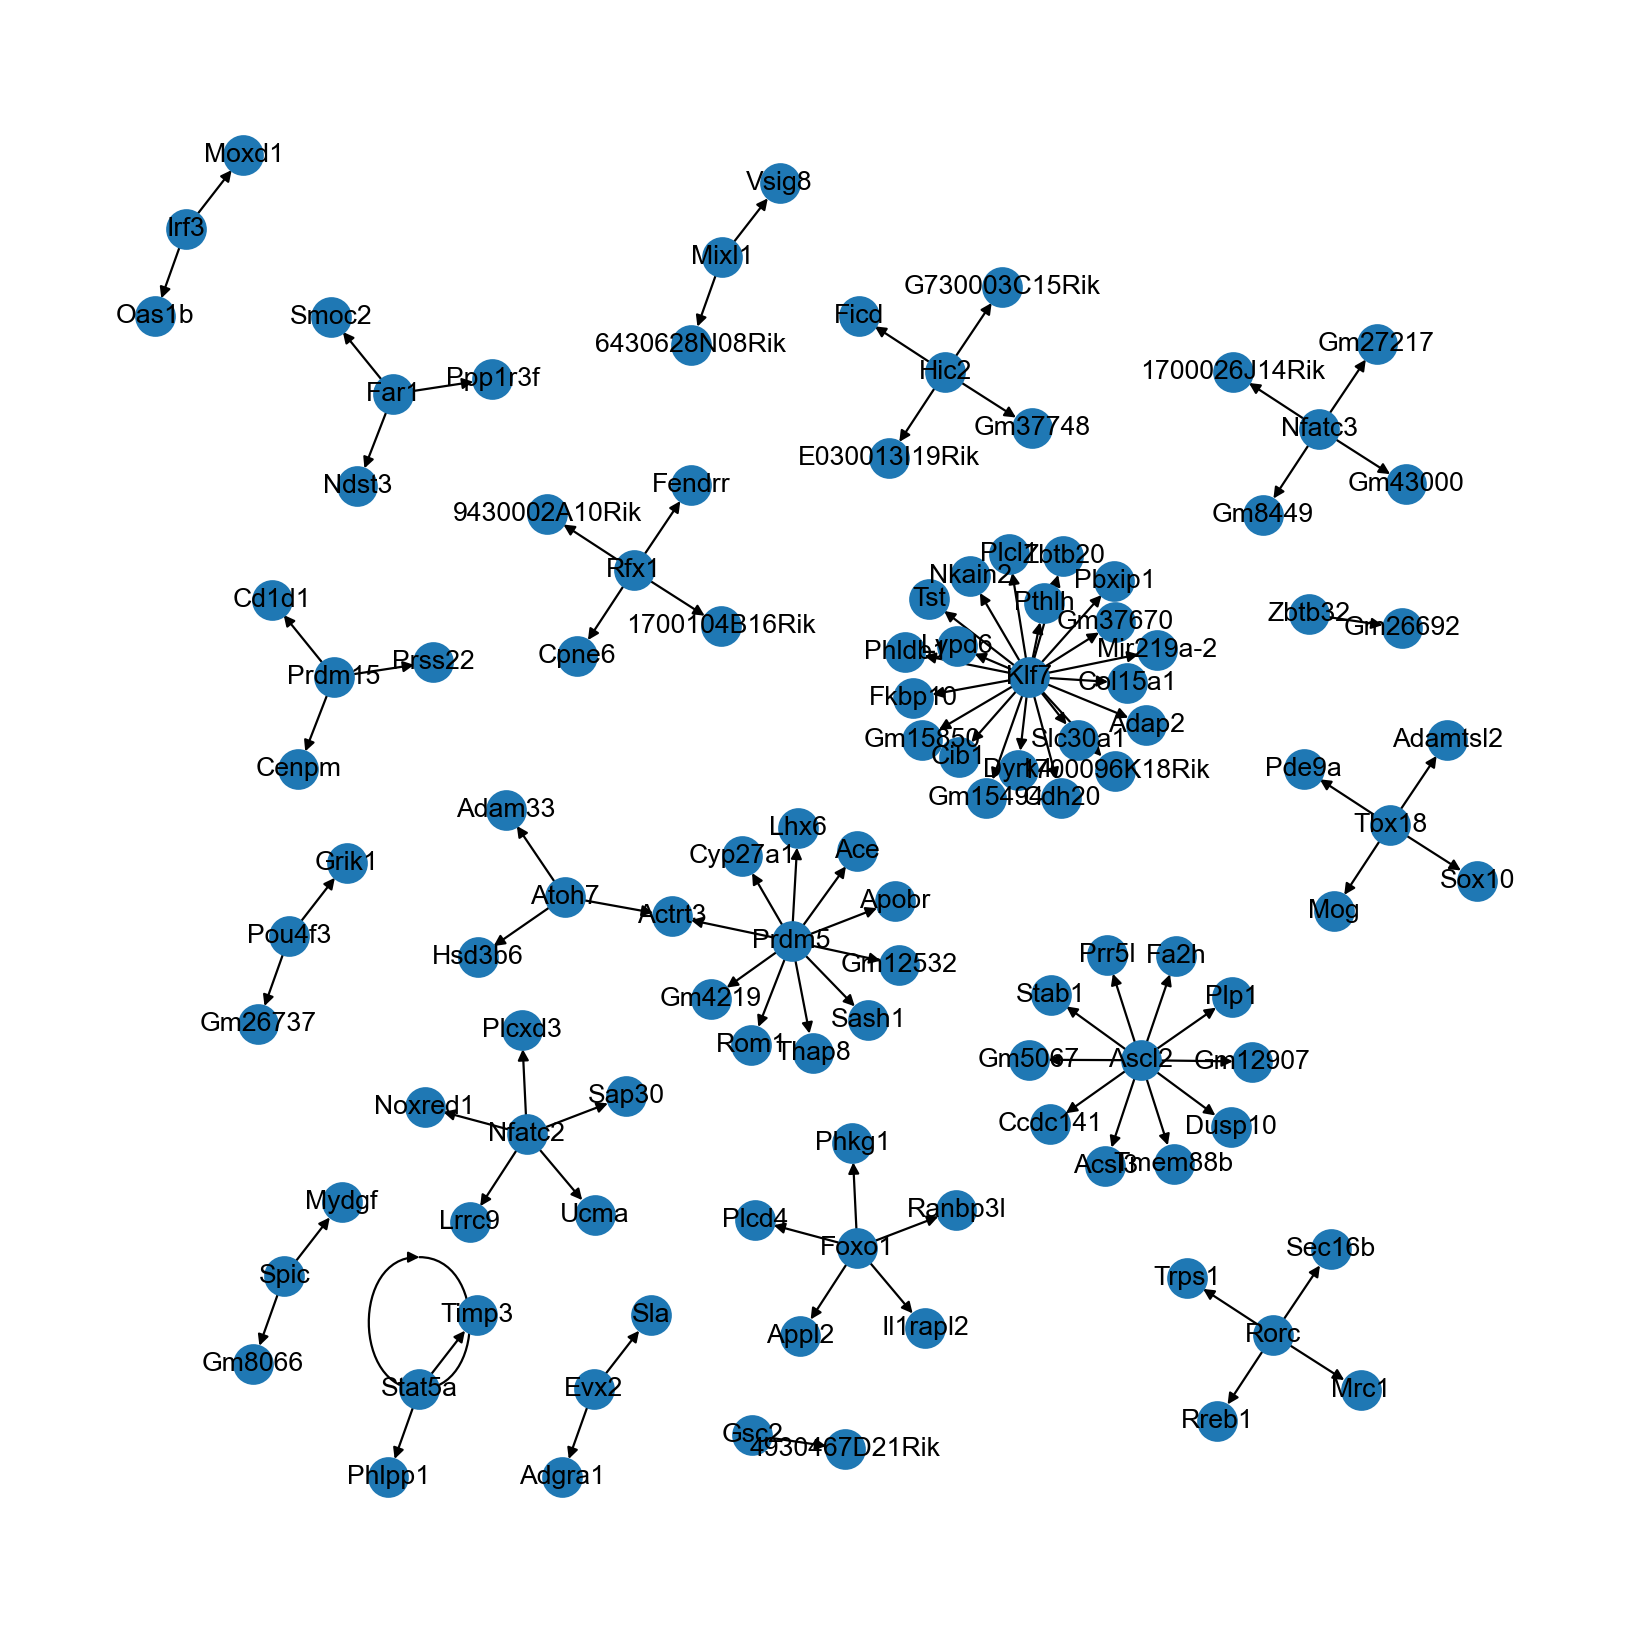

In [26]:
rcParams['figure.figsize'] = (10, 10)
nx.draw(grn, graphviz_layout(grn), with_labels=True)

You may also export the graph (e.g., in `graphml` format) to other softwares like [Cytoscape](https://cytoscape.org/) and [Gephi](https://gephi.org/) for more customization.

In [27]:
nx.write_graphml(grn, "pruned_grn.graphml.gz")

Note that the network inferred here is rather limited in size and connectivity. In real-world data analyses, we recommend:

1. Extending the genomic range (e.g., 150kb around TSS with distance-decaying weight) and incorporate additional information like Hi-C and eQTL (see our [case study](https://github.com/gao-lab/GLUE/tree/master/experiments/RegInf/s01_preprocessing.py)) when building the guidance graph;
2. Increase the number of highly-variable genes (e.g., to 4000 or 6000) to incorporate more genes into the analysis.